# Reshaping Data

This notebook discusses operations to *reshape* data:

1. Collapsing rows through aggregates
2. Joining data frames together (basic joins)
3. Pivoting between wide and long formats

The [Selection](Selection.ipynb) notebook discussed how to select subsets of rows or columns; these operations will change what the rows and columns are, or add new items.

This notebook uses the “MovieLens + IMDB/RottenTomatoes” data from the [HETREC data](https://grouplens.org/datasets/hetrec-2011/).

## Setup

First we will import our modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Then import the HETREC MovieLens data.  A few notes:

- Tab-separated data
- Not UTF-8 - latin-1 encoding seems to work
- Missing data encoded as `\N` (there's a good chance that what we have is a PostgreSQL data dump!)

### Movies

In [2]:
movies = pd.read_csv('hetrec2011-ml/movies.dat', delimiter='\t', encoding='latin1', na_values=['\\N'])
movies.head()

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9.0,73.0,73.0,...,100.0,8.5,17.0,17.0,0.0,100.0,3.7,102338.0,81.0,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28.0,13.0,...,46.0,5.8,5.0,2.0,3.0,40.0,3.2,44587.0,61.0,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36.0,24.0,...,66.0,7.0,6.0,5.0,1.0,83.0,3.2,10489.0,66.0,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25.0,14.0,...,56.0,5.5,11.0,5.0,6.0,45.0,3.3,5666.0,79.0,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19.0,9.0,...,47.0,5.4,5.0,1.0,4.0,20.0,3.0,13761.0,64.0,http://content8.flixster.com/movie/25/54/25542...


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10197 non-null  int64  
 1   title                   10197 non-null  object 
 2   imdbID                  10197 non-null  int64  
 3   spanishTitle            10197 non-null  object 
 4   imdbPictureURL          10016 non-null  object 
 5   year                    10197 non-null  int64  
 6   rtID                    9886 non-null   object 
 7   rtAllCriticsRating      9967 non-null   float64
 8   rtAllCriticsNumReviews  9967 non-null   float64
 9   rtAllCriticsNumFresh    9967 non-null   float64
 10  rtAllCriticsNumRotten   9967 non-null   float64
 11  rtAllCriticsScore       9967 non-null   float64
 12  rtTopCriticsRating      9967 non-null   float64
 13  rtTopCriticsNumReviews  9967 non-null   float64
 14  rtTopCriticsNumFresh    9967 non-null 

### Movie Info

In [4]:
movie_genres = pd.read_csv('hetrec2011-ml/movie_genres.dat', delimiter='\t', encoding='latin1')
movie_genres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [5]:
movie_tags = pd.read_csv('hetrec2011-ml/movie_tags.dat', delimiter='\t', encoding='latin1')
movie_tags.head()

,movieID,tagID,tagWeight
0,1,7,1
1,1,13,3
2,1,25,3
3,1,55,3
4,1,60,1


In [6]:
tags = pd.read_csv('hetrec2011-ml/tags.dat', delimiter='\t', encoding='latin1')
tags.head()

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


### Ratings

In [7]:
ratings = pd.read_csv('hetrec2011-ml/user_ratedmovies-timestamps.dat', delimiter='\t', encoding='latin1')
ratings.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


## Grouping and Aggregating

The group and aggregate operations allow us to collapse multiple rows, that share a common value in one or more columns (the *grouping key*), into a single row.
There are three pieces of a group-aggregate operation:

- The grouping key — one or more columns that are used to identify which rows are in the same group
- The column(s) to aggregate
- The aggregate function(s) to apply

A group/aggregate operation transforms a data frames using thes columns as follows:

- Each *unique combination* of values in the **grouping key** becomes *one row*.  If the grouping key is one column, this means each distinct value of the grouping column will yield one row in the final results.
- The **columns to aggregate** are collapsed into a single value using the specified aggregate function(s).
- Other columns are ignored and do not appear in the output.

### Aggregate to Series

**If we have:** a data frame  
**And we have:** a column identifying each observation's group membership  
**And we want:** a series with an entry for each group, whose value is an aggregate function of another column  
**Then we can:** use `groupby` with one column and the aggregate function.

For example, if we want to find the timestamp of the first rating for each movie, we can group the ratings table by `movieID` and take the `min` of the `timestamp` column:

In [8]:
ratings.groupby('movieID')['timestamp'].min()

movieID
1         876894948000
2         891835167000
3         931525286000
4         951680805000
5         874593700000
             ...      
65088    1230851753000
65091    1230918649000
65126    1231028759000
65130    1231061731000
65133    1231034528000
Name: timestamp, Length: 10109, dtype: int64

This breaks down into a few pieces.  The `groupby` method returns a group-by object:

In [9]:
ratings.groupby('movieID')

The `DataFrameGroupBy` is a iterable over `(key, df)` tuples, where `key` is a single value of the grouping key, and `df` is a data frame containing the group's data (the `next` function gets the next value of an iterable):

In [10]:
next(iter(ratings.groupby('movieID')))

(1,
         userID  movieID  rating      timestamp
 556        170        1     3.0  1162208198000
 639        175        1     4.0  1133674606000
 915        190        1     4.5  1057778398000
 1211       267        1     2.5  1084284499000
 1643       325        1     4.0  1134939391000
 ...        ...      ...     ...            ...
 850646   71420        1     5.0   948256089000
 852838   71483        1     4.0  1035837220000
 853507   71497        1     5.0  1188256917000
 853757   71509        1     4.0  1018636872000
 855327   71529        1     4.5  1162098801000
 
 [1263 rows x 4 columns])

The column selection yields a `SeriesGroupBy`, which is a group-by for a series instead of a frame:

In [11]:
ratings.groupby('movieID')['timestamp']

Finally, calling `min` on this will apply the `min` function to each group, and put the results together into a series.

### Multiple Aggregates

**If we have:** a data frame  
**And we have:** a column identifying each observation's group membership  
**And we want:** a data frame with an entry for each group, with a column for each of one or more aggregate functions of a column  
**Then we can:** use `groupby` with one column and the `.agg` method with aggregate function names

For example, if we want to find the timestamp of the first rating and last ratings for each movie, we can group the ratings table by `movieID` and take the `min` and `max` of the `timestamp` column:

In [12]:
ratings.groupby('movieID')['timestamp'].agg(['min', 'max'])

,min,max
movieID,,
1,876894948000,1231030405000
2,891835167000,1231030891000
3,931525286000,1231099805000
4,951680805000,1229214105000
5,874593700000,1230915209000
...,...,...
65088,1230851753000,1230851753000
65091,1230918649000,1230918649000
65126,1231028759000,1231097168000


Note that in both cases, the resulting frame or series is indexed by the grouping column.

> *Practice: compute the mean and count of the ratings for each movie*

### Counting Values

There's a useful special case of grouped aggregation - counting how many times each distinct value in a column appears.

**If we have:** a series  
**And we want:** a series whose index keys are the values of the original series, and whose values are the number of times each value appeared in the original series  
**Then we can:** use the `value_counts` method:

In [13]:
ratings['rating'].value_counts()

4.0    215773
3.0    155918
3.5    150582
4.5     88652
5.0     71680
2.5     62454
2.0     57188
1.0     21535
1.5     18328
0.5     13488
Name: rating, dtype: int64

We can also sort the results with the `sort_index` method:

In [14]:
ratings['rating'].value_counts().sort_index()

0.5     13488
1.0     21535
1.5     18328
2.0     57188
2.5     62454
3.0    155918
3.5    150582
4.0    215773
4.5     88652
5.0     71680
Name: rating, dtype: int64

`sort_index` applies to both series and data frames.

### Multiple Columns

We can also compute an aggregate over multiple columns at the same time.  For example, if we want to look at the mean critic and audience scores of movies over time, we can group movies by year and take the mean of multiple columns.

**If we have:** a data frame  
**And we have:** one or more columns identifying group membership  
**And we want:** a data frame with the same aggregate computed over all other columns in the frame  
**Then we can:** apply `groupby` and the aggregate function without selecting columns.

We're first going to select and rename columns, like we did at the end of the [Selection notebook](Selection.ipynb).

In [15]:
movie_scores = movies.set_index('id')[['year', 'rtAllCriticsRating', 'rtTopCriticsRating', 'rtAudienceRating']].rename(columns={
    'rtAllCriticsRating': 'All Critics',
    'rtTopCriticsRating': 'Top Critics',
    'rtAudienceRating': 'Audience'
})
movie_scores

,year,All Critics,Top Critics,Audience
id,,,,
1,1995,9.0,8.5,3.7
2,1995,5.6,5.8,3.2
3,1993,5.9,7.0,3.2
4,1995,5.6,5.5,3.3
5,1995,5.3,5.4,3.0
...,...,...,...,...
65088,2008,4.4,4.7,3.5
65091,1934,7.0,0.0,3.7
65126,2008,5.6,4.9,3.3


Now we're going to do the group-by operation:

In [16]:
year_scores = movie_scores.groupby('year').mean()
year_scores

,All Critics,Top Critics,Audience
year,,,
1903,7.600000,0.000000,0.000000
1915,8.000000,0.000000,3.300000
1916,7.800000,0.000000,3.800000
1917,0.000000,0.000000,0.000000
1918,0.000000,0.000000,0.000000
...,...,...,...
2007,5.141278,4.769042,3.062162
2008,4.699357,4.383280,2.853698
2009,4.850000,4.700000,3.192308


There are two other equivalents to this operation.  First, the `agg` function can take one name instead of a list:

In [17]:
movie_scores.groupby('year').agg('mean')

,All Critics,Top Critics,Audience
year,,,
1903,7.600000,0.000000,0.000000
1915,8.000000,0.000000,3.300000
1916,7.800000,0.000000,3.800000
1917,0.000000,0.000000,0.000000
1918,0.000000,0.000000,0.000000
...,...,...,...
2007,5.141278,4.769042,3.062162
2008,4.699357,4.383280,2.853698
2009,4.850000,4.700000,3.192308


Second, the `agg` function can actually take a *function* as its argument:

In [18]:
movie_scores.groupby('year').agg(np.mean)

,All Critics,Top Critics,Audience
year,,,
1903,7.600000,0.000000,0.000000
1915,8.000000,0.000000,3.300000
1916,7.800000,0.000000,3.800000
1917,0.000000,0.000000,0.000000
1918,0.000000,0.000000,0.000000
...,...,...,...
2007,5.141278,4.769042,3.062162
2008,4.699357,4.383280,2.853698
2009,4.850000,4.700000,3.192308


No matter which method we used, we can then quickly do a line plot, which will default to plotting each column as a different colored line, with the index on the *x* axis:

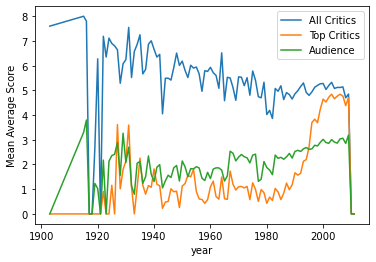

In [19]:
year_scores.plot.line()
plt.ylabel('Mean Average Score')
plt.show()

### Other Grouping Modes

There are a couple of other ways you can use `groupby` and aggregates:

- Select multiple columns from the data frame grouper, by using a list of columns.
- Apply a different aggregate to each function by passing a dictionary to `agg`.
- Apply multiple aggregates to multiple columns by passing a list to `agg` *and* selecting a list of columns.  The resulting data frame has a *hierarchical index* for its columns, which is honestly a little annoying to actually use.
- Group by multiple columns, resulting in a hierarchical index for the rows

Experiment with these on your own!

**Note:** if you use multiple columns, *and* one or more of the columns of the frame is a `Categorical`, groupby will produce a row for each *possible* value, even if one is never observed for that combination of the other grouping keys.  To turn this off, pass the `observed=True` option to [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

## Joining Frames

We can *join* two frames together based on common values of one or more of their columns, possibly using indexes as well.

The simplest way to join two frames without any indexes is with `pd.merge`.

### Column Join

**If we have:** two data frames with at least one column in common  
**And we want:** a data frame with rows based on matching the column values  
**Then we can:** use `pd.merge` to join the frames.

For example, to combine genres with titles:

In [20]:
pd.merge(movies[['id', 'title']].rename(columns={'id': 'movieID'}),
         movie_genres, on='movieID')

,movieID,title,genre
0,1,Toy story,Adventure
1,1,Toy story,Animation
2,1,Toy story,Children
3,1,Toy story,Comedy
4,1,Toy story,Fantasy
...,...,...,...
20804,65126,Choke,Comedy
20805,65126,Choke,Drama
20806,65130,Revolutionary Road,Drama
20807,65130,Revolutionary Road,Romance


If there is more than one row in one table with a match for a value in the other table, it *duplicates* the other row.  So we can see that “Toy story” is duplicated, once for each genre it appears in.

Pull out the selection & rename on `movies` into a new cell for practice, and to see what it does.

### Column/Index Join

The `join` method can do index-index and column-index joins.

**If we have:** a data frame  
**And we have:** another data frame whose index is values appearing in a column of the first frame  
**And we want:** a frame that merges the two frames by matching column values in the first with the index keys of the second  
**Then we can:** use `.join` with the `on` option.

To set this up, we want something with a suitable index.  Let's create a frame that has mean & count of MovieLens user ratings:

In [21]:
movie_stats = ratings.groupby('movieID')['rating'].agg(['mean', 'count'])
movie_stats = movie_stats.rename(columns={'mean': 'MeanRating', 'count': 'RatingCount'})
movie_stats

,MeanRating,RatingCount
movieID,,
1,3.735154,1263
2,2.976471,765
3,2.873016,252
4,2.577778,45
5,2.753333,225
...,...,...
65088,3.500000,1
65091,4.000000,1
65126,3.250000,2


This frame is indexed by movieID. Let's combine that with movie title & year info:

In [22]:
movies[['id', 'title', 'year']].join(movie_stats, on='id')

,id,title,year,MeanRating,RatingCount
0,1,Toy story,1995,3.735154,1263.0
1,2,Jumanji,1995,2.976471,765.0
2,3,Grumpy Old Men,1993,2.873016,252.0
3,4,Waiting to Exhale,1995,2.577778,45.0
4,5,Father of the Bride Part II,1995,2.753333,225.0
...,...,...,...,...,...
10192,65088,Bedtime Stories,2008,3.500000,1.0
10193,65091,Manhattan Melodrama,1934,4.000000,1.0
10194,65126,Choke,2008,3.250000,2.0
10195,65130,Revolutionary Road,2008,2.500000,1.0


Note that we used the `id` column, which is in the `movies` table, as the `on` option.  Join automatically matches it with the index in `movie_stats`.

### Index/Index Join

Let's now see an index-index join.

**If we have:** two data frames with matching indexes  
**And we want:** a frame that merges the two frames matching their index values  
**Then we can:** use `.join` with no extra options.

Remember that `set_index` will set an index on the `movies` frame:

In [23]:
movies.set_index('id')

,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
id,,,,,,,,,,,,,,,,,,,,
1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9.0,73.0,73.0,0.0,100.0,8.5,17.0,17.0,0.0,100.0,3.7,102338.0,81.0,http://content7.flixster.com/movie/10/93/63/10...
2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28.0,13.0,15.0,46.0,5.8,5.0,2.0,3.0,40.0,3.2,44587.0,61.0,http://content8.flixster.com/movie/56/79/73/56...
3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36.0,24.0,12.0,66.0,7.0,6.0,5.0,1.0,83.0,3.2,10489.0,66.0,http://content6.flixster.com/movie/25/60/25602...
4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25.0,14.0,11.0,56.0,5.5,11.0,5.0,6.0,45.0,3.3,5666.0,79.0,http://content9.flixster.com/movie/10/94/17/10...
5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19.0,9.0,10.0,47.0,5.4,5.0,1.0,4.0,20.0,3.0,13761.0,64.0,http://content8.flixster.com/movie/25/54/25542...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65088,Bedtime Stories,960731,Más allá de los sueños,http://ia.media-imdb.com/images/M/MV5BMjA5Njk5...,2008,bedtime_stories,4.4,104.0,26.0,78.0,25.0,4.7,26.0,6.0,20.0,23.0,3.5,108877.0,63.0,http://content6.flixster.com/movie/10/94/33/10...
65091,Manhattan Melodrama,25464,El enemigo público número 1,http://ia.media-imdb.com/images/M/MV5BMTUyODE3...,1934,manhattan_melodrama,7.0,12.0,10.0,2.0,83.0,0.0,4.0,2.0,2.0,50.0,3.7,344.0,71.0,http://content9.flixster.com/movie/66/44/64/66...
65126,Choke,1024715,Choke,http://ia.media-imdb.com/images/M/MV5BMTMxMDI4...,2008,choke,5.6,135.0,73.0,62.0,54.0,4.9,26.0,8.0,18.0,30.0,3.3,13893.0,55.0,http://content6.flixster.com/movie/10/85/09/10...


So we'll set the index, pick a couple columns, and join with movie stats:

In [24]:
movies.set_index('id')[['title', 'year']].join(movie_stats)

,title,year,MeanRating,RatingCount
id,,,,
1,Toy story,1995,3.735154,1263.0
2,Jumanji,1995,2.976471,765.0
3,Grumpy Old Men,1993,2.873016,252.0
4,Waiting to Exhale,1995,2.577778,45.0
5,Father of the Bride Part II,1995,2.753333,225.0
...,...,...,...,...
65088,Bedtime Stories,2008,3.500000,1.0
65091,Manhattan Melodrama,1934,4.000000,1.0
65126,Choke,2008,3.250000,2.0


This has the same result.

### Join Types

There are multiple types of joins.  The types of Pandas joins correspond to SQL join types, if you are familiar with those.

We refer to the frames as *left* and *right*.  These correspond to positions in the functions as follows:

    pd.merge(left, right)
    left.join(right)

- An **inner join** requires a match to appear in both frames.  If there is a row in one frame whose join column value has no match in the other frame, the row is excluded.  This applies to both frames.
- A **left join** includes every row in the left-hand frame at least once; if there is a left-hand row with no match in the right-hand frame, one copy is included with missing values for all of the right-hand columns.  Right-hand rows with no matches in the left frame are excluded.
- A **right join** is the reverse of a left join: it includes every value in the right-hand frame at least once.
- An **outer join** includes every row from both frames at least once.

`pd.merge` defaults to an inner join, and `left.join(right)` defaults to a left join.  Both take a `how=` option to change the merge type.

### Join Tips

The join I find myself using most frequently is a column-index join.  I also usually join on a single column, although multiple-column joins are very well-supported.

## Tall and Wide

As discussed in the video, data comes in *tall* and *wide* formats.  If we observations of multiple variables for something, it can be in either format:

- In **wide** format, each variable is a column
- In **tall** (or **long**) format, each variable produces a new row; there is a column for the variable name and another for the value

We can convert back and forth between them.

### Tall to Wide

The `pivot` function converts tall data to wide data.

First, let's make some tall data.  The movie-tags table has the tags that apply to each movie, along with their *weight*: how important that tag is.  Let's look (joining to `tag` to get the tag names):

In [25]:
movie_tags.join(tags.set_index('id'), on='tagID')

,movieID,tagID,tagWeight,value
0,1,7,1,funny
1,1,13,3,time travel
2,1,25,3,tim allen
3,1,55,3,comedy
4,1,60,1,fun
...,...,...,...,...
51790,65037,792,1,autism
51791,65037,2214,1,internet
51792,65126,5281,1,based on book
51793,65126,13168,1,chuck palahniuk


`value` is a funny name, and once we have name we don't need tag ID, so let's clean up these columns:

In [26]:
movie_tag_weights = movie_tags.join(tags.set_index('id'), on='tagID')
movie_tag_weights = movie_tag_weights[['movieID', 'value', 'tagWeight']]
movie_tag_weights = movie_tag_weights.rename(columns={
    'value': 'tag',
    'tagWeight': 'weight'
})
movie_tag_weights

,movieID,tag,weight
0,1,funny,1
1,1,time travel,3
2,1,tim allen,3
3,1,comedy,3
4,1,fun,1
...,...,...,...
51790,65037,autism,1
51791,65037,internet,1
51792,65126,based on book,1
51793,65126,chuck palahniuk,1


This is in **tall** format: for each movie, we have a row for each tag with its weight.

If we want to turn this into a (very!) **wide** table, with a column for each tag, we can use `pivot`.

**If we have:** a data frame in tall format (one column has variable names, and another their values)  
**And we want:** the same data in wide format (variables split out into columns)  
**Then we can:** use `pivot` to pivot the wide data into tall format:

In [27]:
mtw_wide = movie_tag_weights.pivot('movieID', 'tag', 'weight')
mtw_wide

tag,(s)vcd,007 (series),15th century,16mm,16th century,17th century,1800s,1890s,18th century,1900s,...,zeppelin,zero mostel,zibri studio,zim,ziyi zhang,zombie,zombie movie,zombies,zoo,zooey deschanel
movieID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see a lot of missing values (NaN).  The `describe` method on a data frame will describe all the columns, which will include counting the values.  Let's see it:

In [28]:
mtw_desc = mtw_wide.describe()
mtw_desc

tag,(s)vcd,007 (series),15th century,16mm,16th century,17th century,1800s,1890s,18th century,1900s,...,zeppelin,zero mostel,zibri studio,zim,ziyi zhang,zombie,zombie movie,zombies,zoo,zooey deschanel
count,31.000000,23.000000,2.0,5.0,6.0,10.000000,2.0,4.0,12.000000,7.000000,...,2.0,2.0,9.000000,7.0,2.0,25.00000,3.0,43.000000,2.0,2.0
mean,1.032258,1.043478,1.0,1.0,1.0,1.300000,1.0,1.0,1.583333,1.142857,...,1.0,1.0,1.111111,1.0,1.0,1.52000,2.0,3.465116,1.0,1.0
std,0.179605,0.208514,0.0,0.0,0.0,0.483046,0.0,0.0,0.996205,0.377964,...,0.0,0.0,0.333333,0.0,0.0,0.87178,1.0,3.607854,0.0,0.0
min,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.0
25%,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.000000,1.0,1.0,1.00000,1.5,1.000000,1.0,1.0
50%,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.000000,1.0,1.0,1.00000,2.0,2.000000,1.0,1.0
75%,1.000000,1.000000,1.0,1.0,1.0,1.750000,1.0,1.0,2.000000,1.000000,...,1.0,1.0,1.000000,1.0,1.0,2.00000,2.5,5.000000,1.0,1.0
max,2.000000,2.000000,1.0,1.0,1.0,2.000000,1.0,1.0,4.000000,2.000000,...,1.0,1.0,2.000000,1.0,1.0,4.00000,3.0,19.000000,1.0,1.0


That might look better if we switch columns and rows:

In [29]:
mtw_desc.T

,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
(s)vcd,31.0,1.032258,0.179605,1.0,1.0,1.0,1.0,2.0
007 (series),23.0,1.043478,0.208514,1.0,1.0,1.0,1.0,2.0
15th century,2.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
16mm,5.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
16th century,6.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
zombie,25.0,1.520000,0.871780,1.0,1.0,1.0,2.0,4.0
zombie movie,3.0,2.000000,1.000000,1.0,1.5,2.0,2.5,3.0
zombies,43.0,3.465116,3.607854,1.0,1.0,2.0,5.0,19.0


Ok isn't that kinda cool?

## Stacking Frames

Joins let us combine by merging on values, but sometimes we want to stack data frames on top of each other.  The [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) Pandas function concatenates a list (or other iterable) of data frames.  For example, to simulate a `melt` of the two critic rating columns:

In [30]:
movie_top_rates = movies[['id', 'rtTopCriticsRating']].rename(columns={'rtTopCriticsRating': 'rating'})
movie_top_rates['source'] = 'Top Critics'
movie_all_rates = movies[['id', 'rtAllCriticsRating']].rename(columns={'rtAllCriticsRating': 'rating'})
movie_all_rates['source'] = 'All Critics'

In [31]:
movie_rates = pd.concat([movie_top_rates, movie_all_rates], ignore_index=True)
movie_rates

,id,rating,source
0,1,8.5,Top Critics
1,2,5.8,Top Critics
2,3,7.0,Top Critics
3,4,5.5,Top Critics
4,5,5.4,Top Critics
...,...,...,...
20389,65088,4.4,All Critics
20390,65091,7.0,All Critics
20391,65126,5.6,All Critics
20392,65130,6.7,All Critics


The `ignore_index=True` option causes `pd.concat` to throw away the indexes and make a new `RangeIndex`.  This is fine because the indexes don't contain any useful information.

We can also concatenate with the index; this is most useful when the frames have disjoint indexes, or when we want to add another index level containing the source.  We'll discuss this in the indexing notebook.

### Wide to Tall

What if we want to go the other way? That's what `melt` is for.

Remember our movie stats by year?

In [32]:
year_scores

,All Critics,Top Critics,Audience
year,,,
1903,7.600000,0.000000,0.000000
1915,8.000000,0.000000,3.300000
1916,7.800000,0.000000,3.800000
1917,0.000000,0.000000,0.000000
1918,0.000000,0.000000,0.000000
...,...,...,...
2007,5.141278,4.769042,3.062162
2008,4.699357,4.383280,2.853698
2009,4.850000,4.700000,3.192308


**If we have:** a data frame in wide format  
**And we want:** the same data in tall format  
**Then we can:** use the `melt` method or function.

We first have to reset the index, because melt destroys it:

In [33]:
year_scores.reset_index()

,year,All Critics,Top Critics,Audience
0,1903,7.600000,0.000000,0.000000
1,1915,8.000000,0.000000,3.300000
2,1916,7.800000,0.000000,3.800000
3,1917,0.000000,0.000000,0.000000
4,1918,0.000000,0.000000,0.000000
...,...,...,...,...
93,2007,5.141278,4.769042,3.062162
94,2008,4.699357,4.383280,2.853698
95,2009,4.850000,4.700000,3.192308
96,2010,0.000000,0.000000,0.000000


That pops the year back out to being a column, so we can pass it as the `id_var` to `melt`:

In [34]:
ys_tall = year_scores.reset_index().melt(id_vars='year')
ys_tall

,year,variable,value
0,1903,All Critics,7.600000
1,1915,All Critics,8.000000
2,1916,All Critics,7.800000
3,1917,All Critics,0.000000
4,1918,All Critics,0.000000
...,...,...,...
289,2007,Audience,3.062162
290,2008,Audience,2.853698
291,2009,Audience,3.192308
292,2010,Audience,0.000000


We  can give better names to these things:

In [35]:
ys_tall = year_scores.reset_index().melt(id_vars='year', var_name='Source', value_name='MeanAvgScore')
ys_tall

,year,Source,MeanAvgScore
0,1903,All Critics,7.600000
1,1915,All Critics,8.000000
2,1916,All Critics,7.800000
3,1917,All Critics,0.000000
4,1918,All Critics,0.000000
...,...,...,...
289,2007,Audience,3.062162
290,2008,Audience,2.853698
291,2009,Audience,3.192308
292,2010,Audience,0.000000


This is useful for plotting - year is the *x* axis, score, the *y*, and source the color or hue:

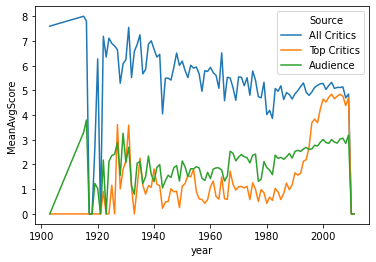

In [36]:
sns.lineplot('year', 'MeanAvgScore', hue='Source', data=ys_tall)

In practice, setting up plots is one of my most frequent use cases for `melt`.  The Pandas defaults we saw earlier are useful, but this give us much more control.